# [ LG에너지솔루션 DX Expert 양성과정 ]

Transformer의 encoder 구조인 BERT를 활용한 text classification
- 이론교육 자료 [ link ](http://dsba.korea.ac.kr/wp-content/uploads/2023/06/9_2%E1%84%8C%E1%85%AE-4%E1%84%8B%E1%85%B5%E1%86%AF-Transformer-%E1%84%80%E1%85%B5%E1%86%B7%E1%84%86%E1%85%B5%E1%84%89%E1%85%AE%E1%86%A8.pdf)

# Import modules

In [ ]:
!pip install transformers==4.29.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.9 MB/s eta 0:00:00


In [ ]:
import json
import os
import re
import random
import numpy as np
import pandas as pd
from collections import defaultdict

from time import time
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score

import gensim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, BertForSequenceClassification , AdamW

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Functions

In [ ]:
def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

def calc_metrics(y_true: list, y_score: np.ndarray, y_pred: list) -> dict:
    auroc = roc_auc_score(y_true, y_score)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)

    return {
        'auroc'    : auroc,
        'f1'       : f1,
        'recall'   : recall,
        'precision': precision
    }

def train(model, dataloader, optimizer, log_interval: int, device: str) -> list:

    correct = 0
    total = 0
    total_loss = 0
    total_score = []
    total_preds = []
    total_targets = []

    model.train()

    for i, batch in enumerate(dataloader):
        inputs, attn_mask, targets = batch

        # convert device
        inputs, attn_mask, targets = inputs.to(device), attn_mask.to(device), targets.to(device)

        # model outputs
        outputs = model(inputs, attention_mask=attn_mask, labels=targets)

        # outputs
        loss = outputs[0]
        logit = outputs[1]

        # calculate gradients
        loss.backward()

        # update model weights
        optimizer.step()
        optimizer.zero_grad()

        # total loss and acc
        total_loss += loss.item()
        preds = logit.argmax(dim=1)

        correct += targets.eq(preds).sum().item()
        total += targets.size(0)

        total_score.extend(logit.cpu().tolist())
        total_preds.extend(preds.cpu().tolist())
        total_targets.extend(targets.cpu().tolist())

        # log learning history
        if i % log_interval == 0 or (i+1) == len(dataloader):
            print('TRAIN [%5d/%5d]: Loss: %.3f | Acc: %.3f%% [%5d/%5d]' %
                 (i+1, len(dataloader), total_loss/(i+1), 100.*correct/total, correct, total))

    # calculate metrics
    metrics = calc_metrics(
        y_true  = total_targets,
        y_score = np.array(total_score)[:,1],
        y_pred  = total_preds
    )

    metrics.update([('acc',correct/total), ('loss',total_loss/len(dataloader))])

    # logging metrics
    print('\nTRAIN: Loss: %.3f | Acc: %.3f%% | AUROC: %.3f%% | F1-Score: %.3f%% | Recall: %.3f%% | Precision: %.3f%%\n' %
         (metrics['loss'], 100.*metrics['acc'], 100.*metrics['auroc'], 100.*metrics['f1'], 100.*metrics['recall'], 100.*metrics['precision']))


    return metrics

def test(model, dataloader, log_interval: int, device: str) -> list:

    correct = 0
    total = 0
    total_loss = 0
    total_score = []
    total_preds = []
    total_targets = []

    torch_seed(223)
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            inputs, attn_mask, targets = batch

            # convert device
            inputs, attn_mask, targets = inputs.to(device), attn_mask.to(device), targets.to(device)

            # model outputs
            outputs = model(inputs, attention_mask=attn_mask, labels=targets)

            # outputs
            loss = outputs[0]
            logit = outputs[1]

            # total loss and acc
            total_loss += loss.item()
            preds = logit.argmax(dim=1)

            correct += targets.eq(preds).sum().item()
            total += targets.size(0)

            total_score.extend(logit.cpu().tolist())
            total_preds.extend(preds.cpu().tolist())
            total_targets.extend(targets.cpu().tolist())

            # log learning history
            if i % log_interval == 0 or (i+1) == len(dataloader):
                print('TEST [%5d/%5d]: Loss: %.3f | Acc: %.3f%% [%5d/%5d]' %
                      (i+1, len(dataloader), total_loss/(i+1), 100.*correct/total, correct, total))

    # calculate metrics
    metrics = calc_metrics(
        y_true  = total_targets,
        y_score = np.array(total_score)[:,1],
        y_pred  = total_preds
    )

    metrics.update([('acc',correct/total), ('loss',total_loss/len(dataloader))])

    # logging metrics
    print('\nTEST: Loss: %.3f | Acc: %.3f%% | AUROC: %.3f%% | F1-Score: %.3f%% | Recall: %.3f%% | Precision: %.3f%%\n' %
         (metrics['loss'], 100.*metrics['acc'], 100.*metrics['auroc'], 100.*metrics['f1'], 100.*metrics['recall'], 100.*metrics['precision']))

    # return
    return metrics


def fit(
    model, trainloader, testloader, optimizer, epochs: int, log_interval: int, device: str) -> list:

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    # fitting model
    for i in range(epochs):
        print(f'\nEpoch: [{i+1}/{epochs}]')
        train_metrics = train(
            model        = model,
            dataloader   = trainloader,
            optimizer    = optimizer,
            log_interval = log_interval,
            device       = device,
        )

        test_metrics = test(
            model        = model,
            dataloader   = testloader,
            log_interval = log_interval,
            device       = device
        )

        # stack history
        for k, v in train_metrics.items():
            train_history[k].append(v)
        for k, v in test_metrics.items():
            test_history[k].append(v)

    return train_history, test_history

# Configuration for experiments

In [ ]:
class Config:
    # dataset 관련 parameters
    datadir = './data'
    dataname = 'naver_shopping.txt'
    train_ratio = 0.6
    max_seq_length = 100

    # model
    pretrained_name = 'klue/bert-base'

    # training 관련 parameters
    epochs = 5
    batch_size = 32
    test_batch_size = 128
    learning_rate = 0.00001
    num_workers = 2
    log_interval = 100

    # device
    device = 'cuda'

    # seed
    seed = 223

cfg = Config()

# Load dataset and dataloader

네이버 쇼핑 리뷰 데이터셋 [[download](https://github.com/bab2min/corpus/tree/master/sentiment)]

In [ ]:
!wget -P ./data https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt

--2023-06-06 12:43:51--  https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20623547 (20M) [text/plain]
Saving to: ‘./data/naver_shopping.txt’

naver_shopping.txt  100%[===================>]  19.67M   126MB/s    in 0.2s    

2023-06-06 12:43:52 (126 MB/s) - ‘./data/naver_shopping.txt’ saved [20623547/20623547]



In [ ]:
with open(os.path.join(cfg.datadir, cfg.dataname),'r',encoding='utf-8') as f:
    data = f.readlines()

In [ ]:
data[:5]

['5\t배공빠르고 굿\n',
 '2\t택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고\n',
 '5\t아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요.\n',
 '2\t선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전화했더니 바로주신다했지만 배송도 누락되어있었네요.. 확인안하고 바로 선물했으면 큰일날뻔했네요..이렇게 배송이 오래걸렸으면 사는거 다시 생각했을거같아요 아쉽네요..\n',
 '5\t민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ\n']

## Preprocessing

In [ ]:
rate = []
label = []
sentence = []
for cur_review in tqdm(data):
    # split rate and sentence(review)
    cur_review = cur_review.split('\t')
    # rate
    rate.append(cur_review[0])
    # sentence(review)
    sentence.append(cur_review[1].strip('\n'))
    # 평점 4,5   : Positive,
    # 평점 1,2,3 : Negative
    if int(cur_review[0]) > 3:
        label.append(0) # positive
    else:
        label.append(1) # negative

  0%|          | 0/200000 [00:00<?, ?it/s]

In [ ]:
sentence[:5]

['배공빠르고 굿',
 '택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고',
 '아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요.',
 '선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전화했더니 바로주신다했지만 배송도 누락되어있었네요.. 확인안하고 바로 선물했으면 큰일날뻔했네요..이렇게 배송이 오래걸렸으면 사는거 다시 생각했을거같아요 아쉽네요..',
 '민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ']

In [ ]:
def preprocess(text):
    text = re.sub('[-=+,#/\?:^$~@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', text)
    text = re.sub('[ㅠㅎㅋ]','', text)
    return text

# regular expression
normalize_sentence = []
for s_i in tqdm(sentence):
    s_i = preprocess(s_i)
    normalize_sentence.append(s_i)

  0%|          | 0/200000 [00:00<?, ?it/s]

In [ ]:
normalize_sentence[:5]

['배공빠르고 굿',
 '택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고',
 '아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요.',
 '선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전화했더니 바로주신다했지만 배송도 누락되어있었네요.. 확인안하고 바로 선물했으면 큰일날뻔했네요..이렇게 배송이 오래걸렸으면 사는거 다시 생각했을거같아요 아쉽네요..',
 '민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ']

In [ ]:
# load pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_name)

# tokenize sentence
print('Sentence')
print(normalize_sentence[1])
print('\nTokenized sentence')
print(tokenizer.tokenize(normalize_sentence[1]))

Sentence
택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고

Tokenized sentence
['택배', '##가', '엉망', '##이', '##네', '##용', '저희', '##집', '밑', '##에', '##층', '##에', '말', '##도', '##없이', '놔두', '##고', '##가', '##고']


In [ ]:
print('Before sampling')
print('len(label): ',len(label))
print('len(normalize_sentence): ',len(normalize_sentence))

# sampling data to reduce dataset size
dataset_size = len(label)

# select sample index
torch_seed(cfg.seed)
select_idx = np.random.choice(range(dataset_size), size=dataset_size//2)

# sampling
label = np.array(label)[select_idx]
normalize_sentence = np.array(normalize_sentence)[select_idx]

print('\nAfter sampling')
print('len(label): ',len(label))
print('len(normalize_sentence): ',len(normalize_sentence))

Before sampling
len(label):  200000
len(normalize_sentence):  200000

After sampling
len(label):  100000
len(normalize_sentence):  100000


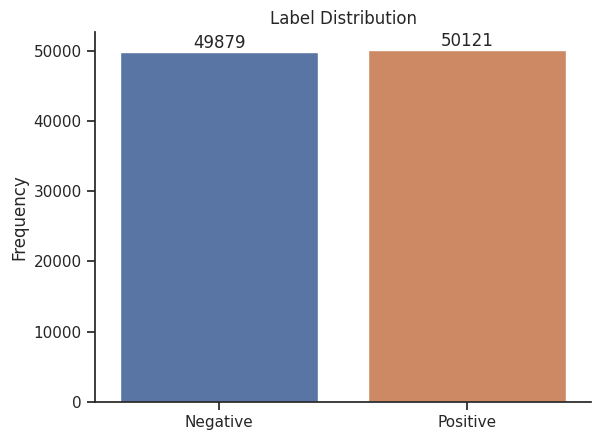

In [ ]:
x, y = np.unique(label, return_counts=True)
ax = sns.barplot(x=x, y=y)
plt.title('Label Distribution')
plt.ylabel('Frequency')
plt.xticks(ticks=[0,1], labels=['Negative','Positive'])
ax.bar_label(ax.containers[0], fmt='%d')
plt.show()

## Split train and test

In [ ]:
dataset_size = len(label)

torch_seed(cfg.seed)
train_idx, test_idx = train_test_split(np.arange(dataset_size), train_size=cfg.train_ratio)

# set train data
x_train = normalize_sentence[train_idx]
y_train = label[train_idx]

# set test data
x_test = normalize_sentence[test_idx]
y_test = label[test_idx]

print('len(x_train): ',len(x_train))
print('len(x_test): ',len(x_test))

len(x_train):  60000
len(x_test):  40000


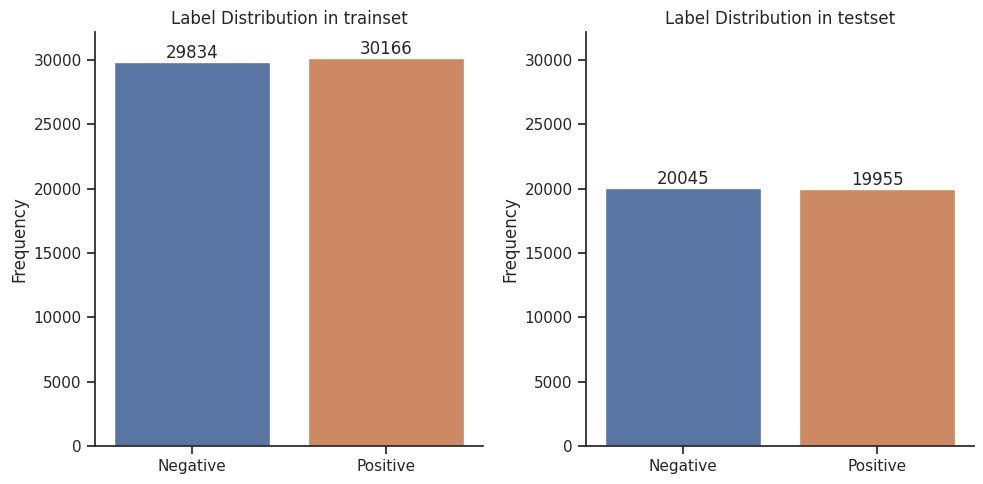

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

# trainset
x, y = np.unique(y_train, return_counts=True)
sns.barplot(x=x, y=y, ax=ax[0])
ax[0].set_title('Label Distribution in trainset')
ax[0].set_ylabel('Frequency')
ax[0].set_xticks(ticks=[0,1], labels=['Negative','Positive'])
ax[0].bar_label(ax[0].containers[0], fmt='%d')
y_max = y.max()

# testset
x, y = np.unique(y_test, return_counts=True)
sns.barplot(x=x, y=y, ax=ax[1])
ax[1].set_title('Label Distribution in testset')
ax[1].set_ylabel('Frequency')
ax[1].set_xticks(ticks=[0,1], labels=['Negative','Positive'])
ax[1].bar_label(ax[1].containers[0], fmt='%d')
if y_max < y.max():
    y_max = y.max()

ax[0].set_ylim(0, y_max+2000)
ax[1].set_ylim(0, y_max+2000)

plt.tight_layout()
plt.show()

## Build Dataset

In [ ]:
class BERTDataset(Dataset):
    def __init__(
        self, inputs: np.ndarray, targets: np.ndarray, tokenizer: AutoTokenizer, max_seq_length: int = 100):

        self.max_seq_length = max_seq_length
        self.tokenizer = tokenizer
        self.inputs = inputs # input sentence는 input 혹은 source라는 단어로 표현됨
        self.targets = targets # output label은 target으로 표현됨

        # define vocab
        self.vocab = self.tokenizer.vocab
        self.pad_idx = self.vocab['[PAD]']
        self.cls_idx = self.vocab['[CLS]']
        self.sep_idx = self.vocab['[SEP]']
        self.mask_idx = self.vocab['[MASK]']

    def convert_inputs_to_feature(self, input):
        # STEP 1 : word to index
        # 문장을 token 단위로 분리한 후, 모델이 이해할 수 있는 형태인 숫자로 바꾸어줍니다
        tokenized_input = self.tokenizer.encode(input)

        # STEP 2 : pad or truncate token
        # max length에 따라 input 문장의 길이 조절하여 동일한 길이의 input으로 변환
        # batch단위로 학습을 하기위해 다음과 같은 과정을 거침
        diff = self.max_seq_length - len(tokenized_input)
        if diff > 0:
            tokenized_input += [self.pad_idx] * diff
        else:
            tokenized_input = tokenized_input[:self.max_seq_length-1] + [self.sep_idx]

        return tokenized_input

    def idx2mask(self, token_ids):
        # output bool; attention mask 생성
        return [token_id != self.pad_idx for token_id in token_ids]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input = self.inputs[idx]
        target = self.targets[idx]

        tokenized_input = self.convert_inputs_to_feature(input)
        att_mask = self.idx2mask(tokenized_input)

        # tokenized input이 max_seq_length와 같은지 무조건 체크
        # att_mask가 max_seq_length와 같은지 무조건 체크
        assert len(tokenized_input) == self.max_seq_length
        assert len(att_mask) == self.max_seq_length

        batch = [
                torch.tensor(tokenized_input),
                torch.tensor(att_mask),
                torch.tensor(target),
        ]
        return batch

In [ ]:
trainset = BERTDataset(inputs=x_train, targets=y_train, tokenizer=tokenizer, max_seq_length=cfg.max_seq_length)
testset = BERTDataset(inputs=x_test, targets=y_test, tokenizer=tokenizer, max_seq_length=cfg.max_seq_length)

trainloader = DataLoader(trainset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
testloader = DataLoader(testset, batch_size=cfg.test_batch_size, shuffle=False, num_workers=cfg.num_workers)

In [ ]:
print('[PAD] index: ',trainset.pad_idx)
print('[CLS] index: ',trainset.cls_idx)
print('[SEP] index: ',trainset.sep_idx)
print('[MASK] index: ',trainset.mask_idx)

[PAD] index:  0
[CLS] index:  2
[SEP] index:  3
[MASK] index:  4


In [ ]:
print('[Sentence]')
print(trainset.inputs[0])
print('\n[Tokenized input]')
print('size: ',len(trainset[0][0]))
print(trainset[0][0])
print('\n[Attention mask]')
print('size: ',len(trainset[0][1]))
print(trainset[0][1])
print('\n[Target]')
print(trainset[0][2])

[Sentence]
택배가 인천까지가서 엄청 걱정했는데 월요일날와서 바로 설치 했습니다. 이쁘네요. 재질도 부들부들하고

[Tokenized input]
size:  100
tensor([    2,  9678,  2116,  4068,  2299, 20257,  2112,  4794,  4419,  2371,
        13964, 10132,  2401, 10362,  3785,  4198,  1902,  2219,  3606,    18,
        13854,  2203,  2182,    18, 15495,  2119, 23701, 19521,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

[Attention mask]
size:  100
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, 

# BERT for sequence classification

In [ ]:
model = BertForSequenceClassification.from_pretrained(cfg.pretrained_name)
model = model.to(cfg.device)

# optimizer
optimizer = AdamW(model.parameters(), lr=cfg.learning_rate)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [ ]:
torch_seed(cfg.seed)
train_history, test_history = fit(
    model        = model,
    trainloader  = trainloader,
    testloader   = testloader,
    optimizer    = optimizer,
    epochs       = cfg.epochs,
    log_interval = cfg.log_interval,
    device       = cfg.device
)


Epoch: [1/5]
TRAIN [    1/ 1875]: Loss: 0.676 | Acc: 68.750% [   22/   32]
TRAIN [  101/ 1875]: Loss: 0.332 | Acc: 87.036% [ 2813/ 3232]
TRAIN [  201/ 1875]: Loss: 0.289 | Acc: 89.195% [ 5737/ 6432]
TRAIN [  301/ 1875]: Loss: 0.268 | Acc: 90.158% [ 8684/ 9632]
TRAIN [  401/ 1875]: Loss: 0.255 | Acc: 90.726% [11642/12832]
TRAIN [  501/ 1875]: Loss: 0.246 | Acc: 90.999% [14589/16032]
TRAIN [  601/ 1875]: Loss: 0.239 | Acc: 91.259% [17551/19232]
TRAIN [  701/ 1875]: Loss: 0.234 | Acc: 91.485% [20522/22432]
TRAIN [  801/ 1875]: Loss: 0.229 | Acc: 91.678% [23499/25632]
TRAIN [  901/ 1875]: Loss: 0.225 | Acc: 91.797% [26467/28832]
TRAIN [ 1001/ 1875]: Loss: 0.223 | Acc: 91.814% [29410/32032]
TRAIN [ 1101/ 1875]: Loss: 0.219 | Acc: 91.950% [32396/35232]
TRAIN [ 1201/ 1875]: Loss: 0.218 | Acc: 91.996% [35356/38432]
TRAIN [ 1301/ 1875]: Loss: 0.216 | Acc: 92.093% [38340/41632]
TRAIN [ 1401/ 1875]: Loss: 0.213 | Acc: 92.231% [41349/44832]
TRAIN [ 1501/ 1875]: Loss: 0.211 | Acc: 92.297% [44332/4

In [ ]:
def figure(all_train_history: list, all_test_history: list, all_exp_name: list) -> None:
    fig, ax = plt.subplots(2, 6, figsize=(20,7))

    # train line plot
    for train_h, exp_name in zip(all_train_history, all_exp_name):
        for i, (k, v) in enumerate(train_h.items()):
            sns.lineplot(
                x     = range(1, len(v)+1),
                y     = v,
                label = exp_name,
                ax    = ax[0, i]
            )
            # set y axis label
            ax[0, i].set_ylabel(f'{k.upper()}')
            # set x axis label
            ax[0, i].set_xlabel('Epochs')
            # set title
            ax[0, i].set_title(f'{k.upper()} of Trainset')
            # set legend
            ax[0, i].legend(loc='lower right')


    # test lineplot
    for test_h, exp_name in zip(all_test_history, all_exp_name):
        for i, (k, v) in enumerate(test_h.items()):
            sns.lineplot(
                x     = range(1, len(v)+1),
                y     = v,
                label = exp_name,
                ax    = ax[1, i]
            )
            # set y axis label
            ax[1, i].set_ylabel(f'{k.upper()}')
            # set x axis label
            ax[1, i].set_xlabel('Epochs')
            # set title
            ax[1, i].set_title(f'{k.upper()} of Testset')
            # set legend
            ax[1, i].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

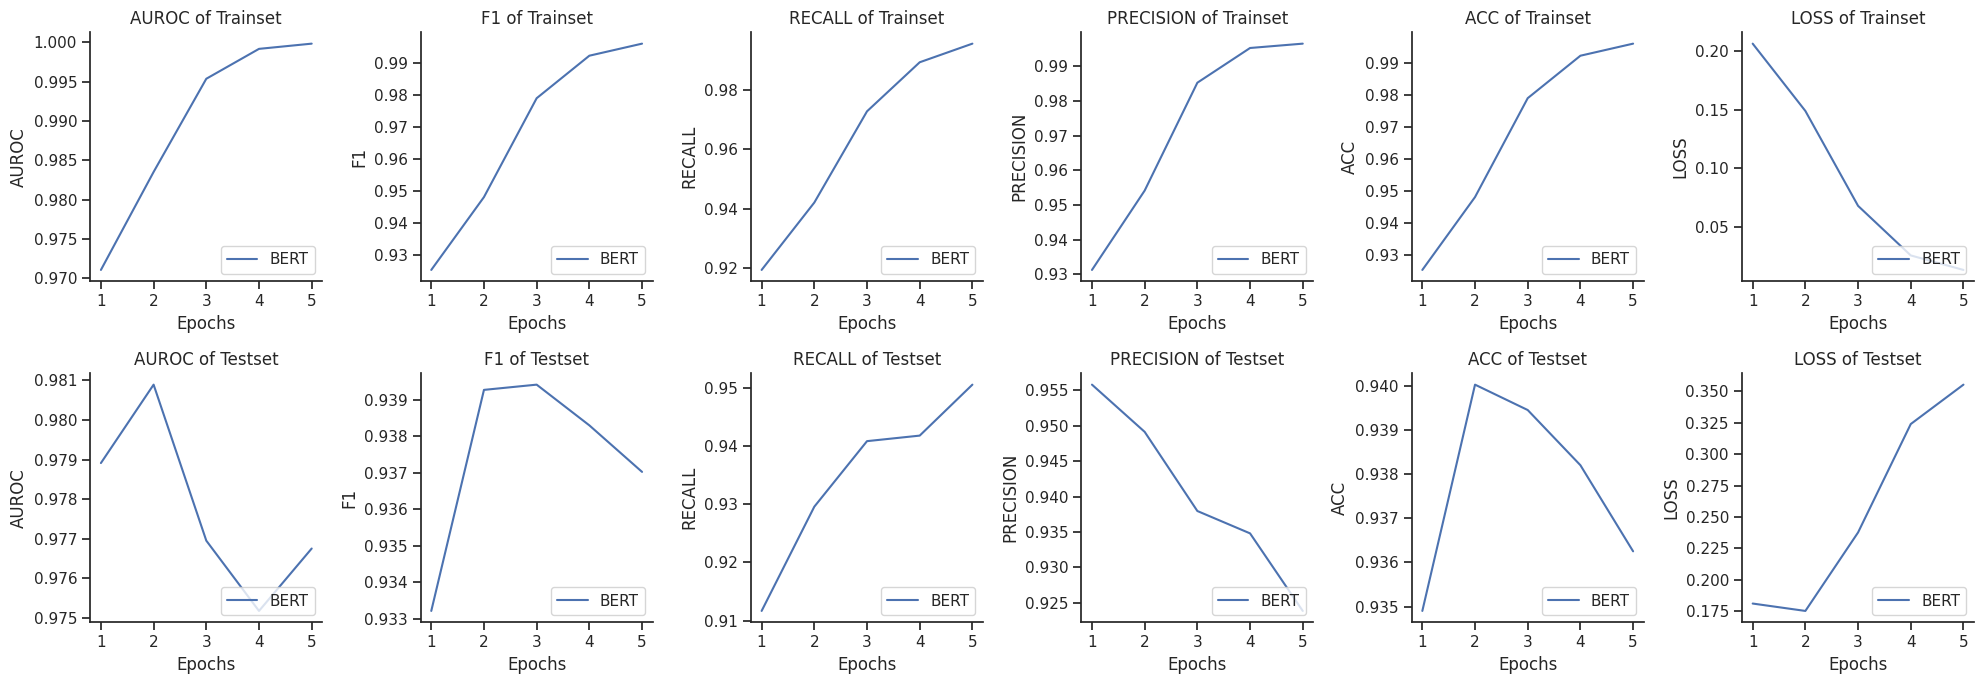

In [ ]:
all_train_history = [train_history]
all_test_history = [test_history]
all_exp_name = ['BERT']

figure(
    all_train_history = all_train_history,
    all_test_history  = all_test_history,
    all_exp_name      = all_exp_name
)